In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

import numpy as np

torch.__version__

'1.11.0'

In [3]:
config = {
    'input_size': 16,
    'output_size': 16,
    'network_height': 64,
    'epochs': 100,
}

In [4]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(config['input_size'], config['network_height'])
        self.fc2 = nn.Linear(config['network_height'], config['network_height'])
        self.dropout = torch.nn.Dropout(p=0.1, inplace=False)
        self.fc3 = nn.Linear(config['network_height'], config['output_size'])

    def forward(self, x):
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(F.relu(x)))
        return x


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
)


In [6]:
def bytes_to_float_array(input, size):
    assert isinstance(input, bytes)
    input = bin(int.from_bytes(input, 'little'))
    input = input[2:]
    output = torch.zeros(16, dtype=torch.float32)
    for i, b in enumerate(input):
        output[i] = float(b)
    return output
        

In [7]:
from dataclasses import dataclass
from typing import Callable
from typing import Any

from crypto import pad

@dataclass(slots=True)
class CryptoDataset:
    crypto_func: Any # Write out the type
    key: str
    input_vector: bytes
    input_size: int
    size: int
    n: int = 0
        
    def encrypt(self, input):
        return int(torch.tensor(np.frombuffer(self.crypto_func(input, self.key, self.input_vector), dtype=np.uint8)[8:]).float(), base=16)
    
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < self.size:
            self.n += 1
            label = str(np.random.randint(10,100)) # pad(str(self.n)[:self.input_size-1], self.input_size)
            return (bytes_to_float_array(self.crypto_func(label, self.key, self.input_vector)[8:], 16), 
                    bytes_to_float_array(label.encode('utf-8'), 16))
        else:
            raise StopIteration

In [8]:
from crypto import encrypt_des

dataloader = CryptoDataset(crypto_func=encrypt_des,
                           key='12345678',
                           input_vector=b'12345678', 
                           input_size=config['input_size'],
                           size=1000
                          )

In [9]:
input, label =  next(dataloader)
out = net(input)
print(f'{input} ({input.shape}),\n{out}({out.shape})\n{label=}({label.shape=})) ')

tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.]) (torch.Size([16])),
tensor([0.4795, 0.5026, 0.4634, 0.4592, 0.4812, 0.4964, 0.4966, 0.4564, 0.4698,
        0.4965, 0.4998, 0.4927, 0.4706, 0.4898, 0.4981, 0.5187],
       grad_fn=<SigmoidBackward0>)(torch.Size([16]))
label=tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.])(label.shape=torch.Size([16]))) 


/Users/mkojro/miniforge3/envs/nn-crypto/lib/python3.10/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [10]:
writer.add_graph(net, input)
writer.close()

In [11]:
def loss_func(input, output):
    input = bin(input.type(torch.uint8).item())[2:5]
    output = bin(output.type(torch.uint8).item())[2:5]
    same = 0
    for i, o in zip(input, output):
        if i == o:
            same += 1
        else:
            break
    return torch.tensor(1 - (same / len(input)), requires_grad=True)

In [12]:
import torch.optim as optim

criterion = nn.L1Loss() # loss_func #nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
for epoch in range(config['epochs']):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels  = data # torch.tensor([float(i)]) / 100, torch.tensor([float(i+10)]) / 100

        # inputs, labels  = inputs/ -256, labels.reshape(-1, 0) / -256

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        writer.add_scalar("Loss/train", loss, epoch)

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


[1,   200] loss: 0.049
[1,   400] loss: 0.048
[1,   600] loss: 0.046
[1,   800] loss: 0.042
[1,  1000] loss: 0.038
[2,   200] loss: 0.032
[2,   400] loss: 0.026
[2,   600] loss: 0.024
[2,   800] loss: 0.022
[2,  1000] loss: 0.022
[3,   200] loss: 0.021
[3,   400] loss: 0.020
[3,   600] loss: 0.020
[3,   800] loss: 0.020
[3,  1000] loss: 0.020
[4,   200] loss: 0.020
[4,   400] loss: 0.020
[4,   600] loss: 0.019
[4,   800] loss: 0.019
[4,  1000] loss: 0.019
[5,   200] loss: 0.019
[5,   400] loss: 0.019
[5,   600] loss: 0.019
[5,   800] loss: 0.019
[5,  1000] loss: 0.019
[6,   200] loss: 0.018
[6,   400] loss: 0.019
[6,   600] loss: 0.018
[6,   800] loss: 0.019
[6,  1000] loss: 0.019
[7,   200] loss: 0.019
[7,   400] loss: 0.019
[7,   600] loss: 0.019
[7,   800] loss: 0.019
[7,  1000] loss: 0.019
[8,   200] loss: 0.019
[8,   400] loss: 0.019
[8,   600] loss: 0.020
[8,   800] loss: 0.018
[8,  1000] loss: 0.019
[9,   200] loss: 0.018
[9,   400] loss: 0.018
[9,   600] loss: 0.019
[9,   800] 

In [27]:
label = '2'
net(bytes_to_float_array(encrypt_des(label, '12345678', b'12345678')[8:], 16)), bytes_to_float_array(label.encode('utf-8'), 16)

/Users/mkojro/miniforge3/envs/nn-crypto/lib/python3.10/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(tensor([0.9574, 0.9411, 0.0417, 0.0746, 0.1034, 0.2489, 0.0339, 0.0516, 0.9515,
         0.9527, 0.0490, 0.9666, 0.9803, 0.0573, 0.0403, 0.0346],
        grad_fn=<SigmoidBackward0>),
 tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [28]:
def to_bytes():
  pass  

In [59]:
label = '6'
ok = 0
for i in range(10,100):
    label = str(i)
    ok += 16 - sum(np.abs(np.round(net(bytes_to_float_array(encrypt_des(label, '12345678', b'12345678')[8:], 16)).detach().numpy(), 0) - bytes_to_float_array(label.encode('utf-8'), 16).numpy()))

ok = ok // (90)
ok

14.0

In [68]:
import math

def bernouli(k, n=16, p=0.5):
    return (math.comb(n,k) * (p**k) * ((1-p)**(n-k)))


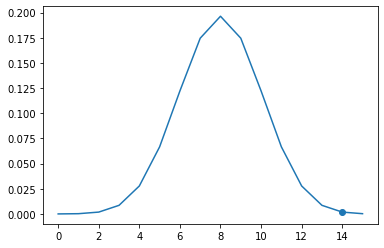

In [70]:
import matplotlib.pyplot as plt

plt.plot([bernouli(i) for i in range(16)])
plt.scatter([ok],bernouli(int(ok)))

In [65]:
def evaluator(label):
    return sum(np.abs(np.round(net(bytes_to_float_array(encrypt_des(label, '12345678', b'12345678')[8:], 16)).detach().numpy(), 0) - bytes_to_float_array(label.encode('utf-8'), 16).numpy()))

In [62]:
label = '99'
np.round(net(bytes_to_float_array(encrypt_des(label, '12345678', b'12345678')[8:], 16)).detach().numpy(), 0) - bytes_to_float_array(label.encode('utf-8'), 16).numpy()

/Users/mkojro/miniforge3/envs/nn-crypto/lib/python3.10/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
        0.,  0.,  0.], dtype=float32)